Notebook Linear Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data: target is beter doen dan 30% nauwkeurigheid

Extra:
- er wordt logging voorzien voor en na de belangrijke stappen (zie LinReg_logging.log). Hiermee kunnen de stappen en de resultaten opgevolgd worden
- 

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance/data
- Metadata :
age: age of primary beneficiary
sex: insurance contractor gender, female, male
bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
children: Number of children covered by health insurance / Number of dependents
smoker: Smoking
region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
charges: Individual medical costs billed by health insurance


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- data summarizen via summarytools 
- missing en duplicated data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- Linear Regression toepassen




In [16]:
# import van de diverse modules

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix, accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info, log_error, log_warning: 
- logging functies om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
log_info_write_to_file: schrijf de loginformatie naar file 
log_info_print_on_screen: print alle loginfo naar het scherm

In [17]:
# enkele extra code snippets gebruikt doorheen de oefening

plot_graphs = True

# schrijf een visual naar file
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# functies om te loggen naar file
# Lezen van de JSON-file
log_info_lijst = []

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

def log_info(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : INFO : {boodschap}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_error(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Fore.RED}{formatted_date} : ERROR : {boodschap}{Style.RESET_ALL}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_warning(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Fore.YELLOW}{formatted_date} : WARNING : {boodschap}{Style.RESET_ALL}"
    log_info_lijst.append(log_message)
    print(log_message)
    return


def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

In [18]:
# data bestand inlezen

insurance_data_filename = 'data/insurance.csv'
df = pd.read_csv(insurance_data_filename)
log_info(f"File {insurance_data_filename}")

09/02/2025 10:21:32 : INFO : File data/insurance.csv


In [19]:
# enkele eenvoudige controles

log_info(f"df.info : \n{df.info()}")
log_info(f"df.describe : \n{df.describe()}")

# geen nulwaarden 

from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
09/02/2025 10:21:32 : INFO : df.info : 
None
09/02/2025 10:21:33 : INFO : df.describe : 
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 39.2 (14.0)min < med < max:18.0 < 39.0 < 64.0IQR (CV) : 24.0 (2.8),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACXUlEQVR4nO3cT4riQBiH4a/GVuMfEkTQnRcYmIXLHGIOO0fohSfwBu4EkYjpDsaYWQzSMwOjnTgxv+j7bJtKS/FamsKKy/PcABVf6n4BwO9eLv3ROdczs07Jax/yPH8vORZP6p9BOud64/H4u+/7ozIX3u12W+fcD6JEEZdWyI7v+6MwDN+DIEiKXDSKIm+xWIw2m03HzAgSn3bxI9vMLAiCZDKZvJW4dq/EGDw5bmoghSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAh5eovxlE9DtN9IMiacZjuT5UFmWVZ28x851yZ4Y1719+wyvnD4XAShuGOw3QVBRnHcTtN02+z2azVarUKTbJZ8971t6xyaZp6WZZ97Xa7rxymqyjIw+Hw4nlefz6fJ9PpdFtkbEPf9aWPDK9Wq9Fyuewfj8dWVS+uSSr9DjkYDO5+hLbOG4QyR4a3221tK5zizdRD3dRwg/B5qnP1UEEaT9soQnKuHi1IM+NpG0WozdVDBvlMbthe80+nU7uG/2t24funZJB1TXLT3LK9dt5uSpLk1cwKrZBVbuvJBVnXJDfRLdtrt2w3VbmtJxdkXZNs1tyVucz22v/YbqpiW08uyLN7TzIrswbZIO+tzpUZHwjyL3V9/OEXfqALKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKVcfFBBFkVf0ovv93jMzi+PYW6/XfcYy9uxaTz8BiY60rVdc/9gAAAAASUVORK5CYII="">",0(0.0%)
2,sex[object],1. male2. female,676 (50.5%)662 (49.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,bmi[float64],Mean (sd) : 30.7 (6.1)min < med < max:16.0 < 30.4 < 53.1IQR (CV) : 8.4 (5.0),548 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3bwYraQBzH8f/UdYkKEbHozRco9ODRh+jD9hEq+AS+gTchSMTUYIzpoQvtFnaXjJPmt9nv5z6YwxfDZP7jqqoyQMWnth8A+NtD2w8QmnNuYGaPnssvVVWdQz4P6ulUkM65wXQ6/RbH8cRn/fF4PDjnvhNlezoVpJk9xnE8Wa1W5/F4nNdZmKZptNlsJkmSPJoZQbaka0Gamdl4PM5ns9lPj6WD4A+DWtjUQApBQkonX9m+yrLsm1nsnPNZzg49AIJ8kmVZvyiKr4vFotfr9WptiMzYoYdCkE8ul8tDFEXD5XKZz+fzQ5217NDDIch/jEYjdugtYlMDKQQJKQQJKQQJKQQJKQQJKZKffe6YaYxvt1s/9PPg/5EL8p6ZxqIoorIsv+R5/sPMfL4lomVyQdodM4273W6y3W6H1+u119TDoVmKQZqZ30zj4XDgtOSdY1MDKQQJKQQJKQQJKbKbmveGafMwCDIAps3DIcgAmDYPhyADYtr8fmxqIIUgIYUgIYUgIYUgIYUgIYUgIYUgIYUgIaWxkxouasFHI0FyUQu+mvqH5KIWvDQ6XMFFLdTFpgZSCBJSmIcUwPWHPwiyZVx/eI4gW8b1h+cIUgTXH35jUwMpBAkpBAkpBAkpBAkpBAkpBAkpBAkpr34YZ+pbX9fOwV8MkqlvfV08B3/tH5Kpb3FdPAd/8yybqW99vufgZVnGJva6Z7jig1J93RPkB3Xv6369Xs+SJPnsnDv6/PxLIb8ZZJqmUd1fO51OkZlZlmXRfr8fslZ3rY/z+dzYv+svSFme8aj5M/MAAAAASUVORK5CYII="">",0(0.0%)
4,children[int64],1. 02. 13. 24. 35. 46. 5,574 (42.9%)324 (24.2%)240 (17.9%)157 (11.7%)25 (1.9%)18 (1.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dQU7bUBiF0T9RRJuJowiJZbCALKKL7SKygOwDRXjQUCbpoJTSDoCBfZ9lnzNj9pA+vciRr7K6Xq8FCevWB2A5xEaM2IgRGzGrqtpW1U3rg0zA8/V6vbQ+xJxtbm9vv3Vdt299kNb6vj+vVqvvghvPpuu6/eFwuOx2u6fWh2nl8fHx6/F43D88PNxUldhGsqmq2u12T3d3dz9aH6axbesDzJ0HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1+xWb1gdpaen/f8qm7/vz8Xjc18Jfsen7/lxVz63PMWdeC//La+EjWxkpkzLlm81NMzOTHbwYoMzPJAcvBijzNOXBy6KfjufIl7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJnkumpq52EYk11XWTvNjw0CMdZVxLS42dxYCxVfV1lNLVd0XWU1tWwt1lWTeuolx5e6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IiJrqusppYtvq6ymlouGwRirKuIGfJmc2PxrsHWVVZTfGSQdZXVFJ8x

In [20]:
# drie categorische features: smoking, region en sex
# vier numerische features waaronder de target variabele "charges"
# maak de datasets aan 

df_cat_col = ['smoker','region','sex']
df_num_col = ['age', 'bmi','children','charges']
df_label_col = ['charges']

# zijn er nominaal categorische variabelen en één ordinal categorische waarden?
df_cat_nom_col = ['smoker','region']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

In [21]:
# korte analyze van de categorische variabelen
df_cat.value_counts()

# check op nullen
nul_waarden = df.isnull().sum()
log_info(f"Check op nulwaarden \n{nul_waarden}")
# geen nullen

#check op duplicates
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates \n{duplicate_waarden}")
#  oeps er is er één
# drop it

df.drop_duplicates(inplace=True)
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates na drop \n{duplicate_waarden}")
log_info_write_to_file('LinReg_logging.log')

09/02/2025 10:21:33 : INFO : Check op nulwaarden 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
09/02/2025 10:21:33 : INFO : Check op duplicates 
1
09/02/2025 10:21:33 : INFO : Check op duplicates na drop 
0


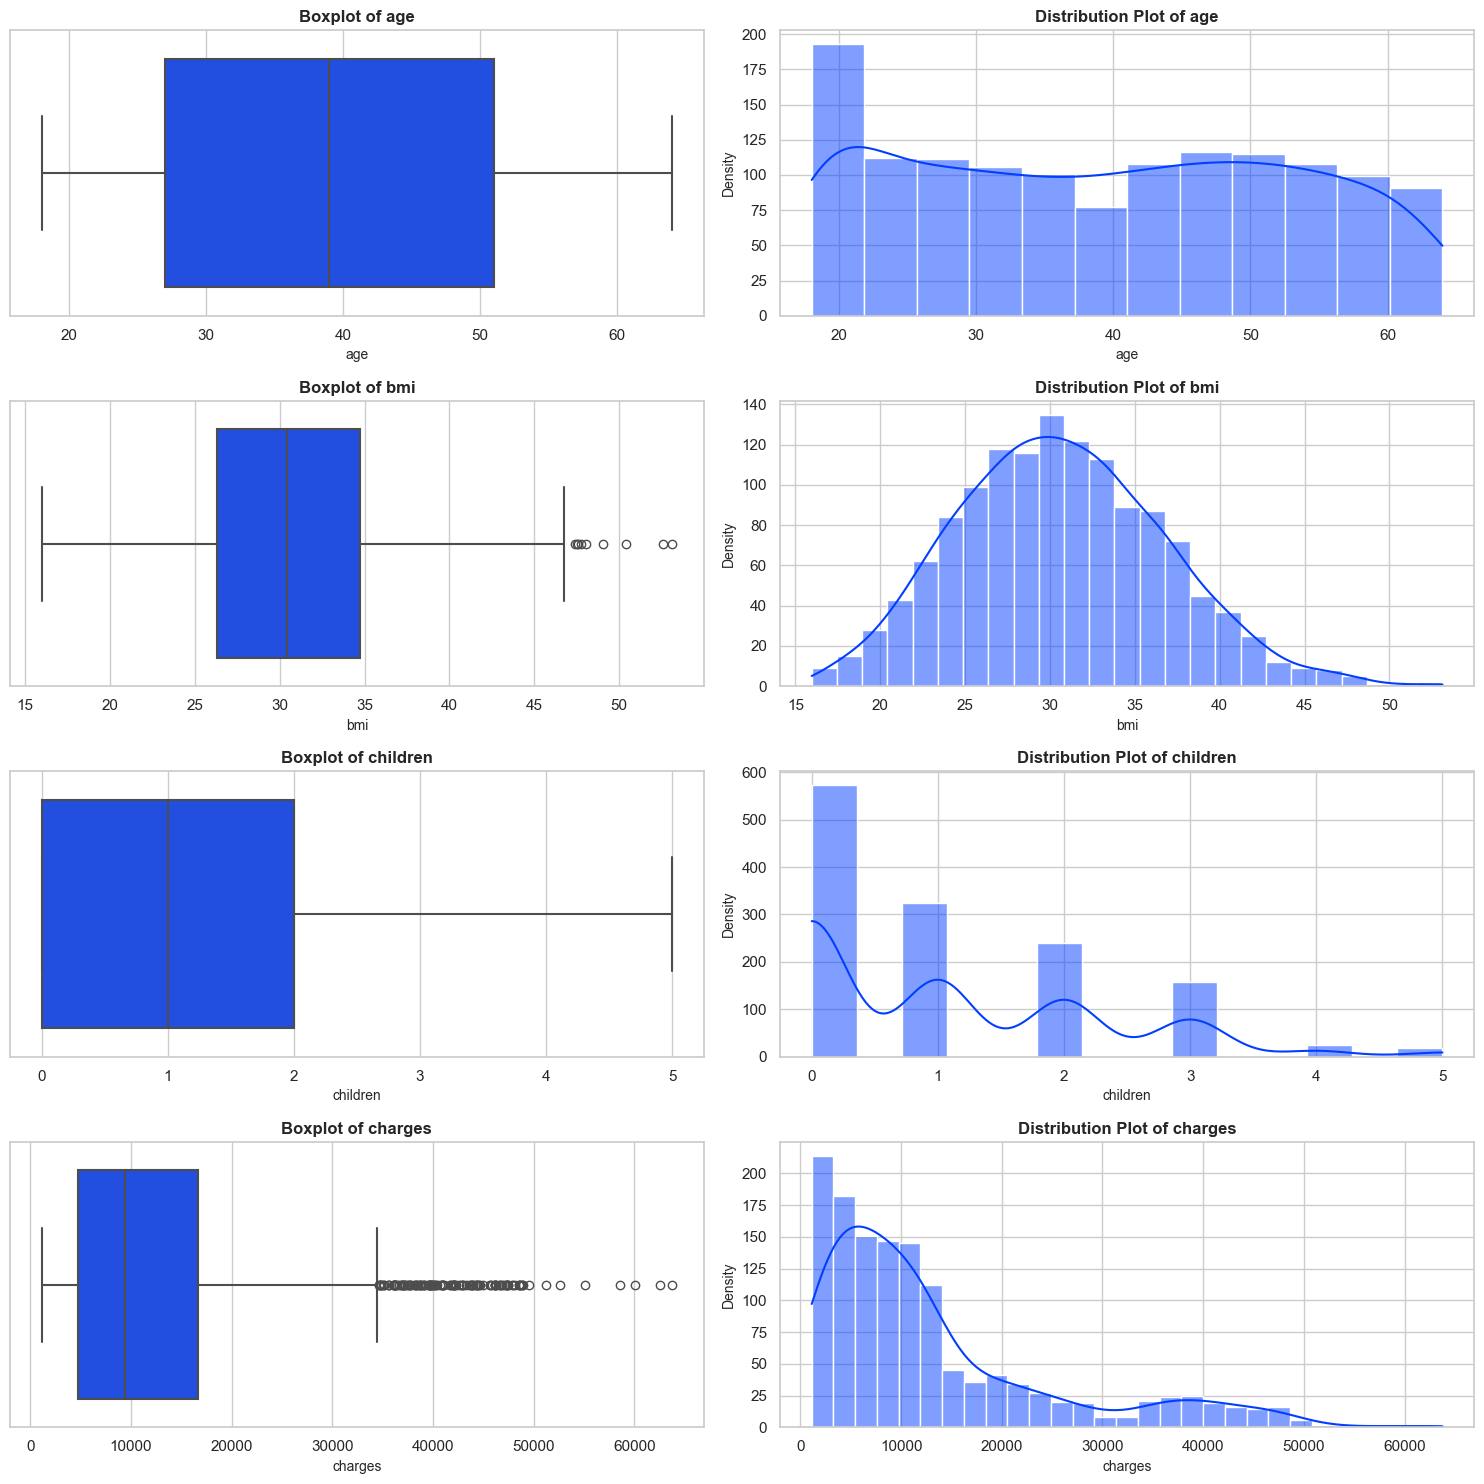

09/02/2025 10:21:36 : INFO : Check van numerische features


In [22]:
# boxplot van de numerische waarden
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, 15)) 
for i, col in enumerate(df_num_col):
    plt.subplot(len(df_num_col), 2, 2 * i + 1)
    sns.boxplot(x=df[col], orient='h', linewidth=1.5)
    plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)

    plt.subplot(len(df_num_col), 2, 2 * i + 2)
    sns.histplot(df[col], kde=True,  linewidth=1)
    plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Density", fontsize=10)

plt.tight_layout()
save_fig("Numerische features boxplot")
plt.show()

log_info("Check van numerische features")

C:\Users\geert\AppData\Local\Temp\ipykernel_61072\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_61072\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_61072\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')


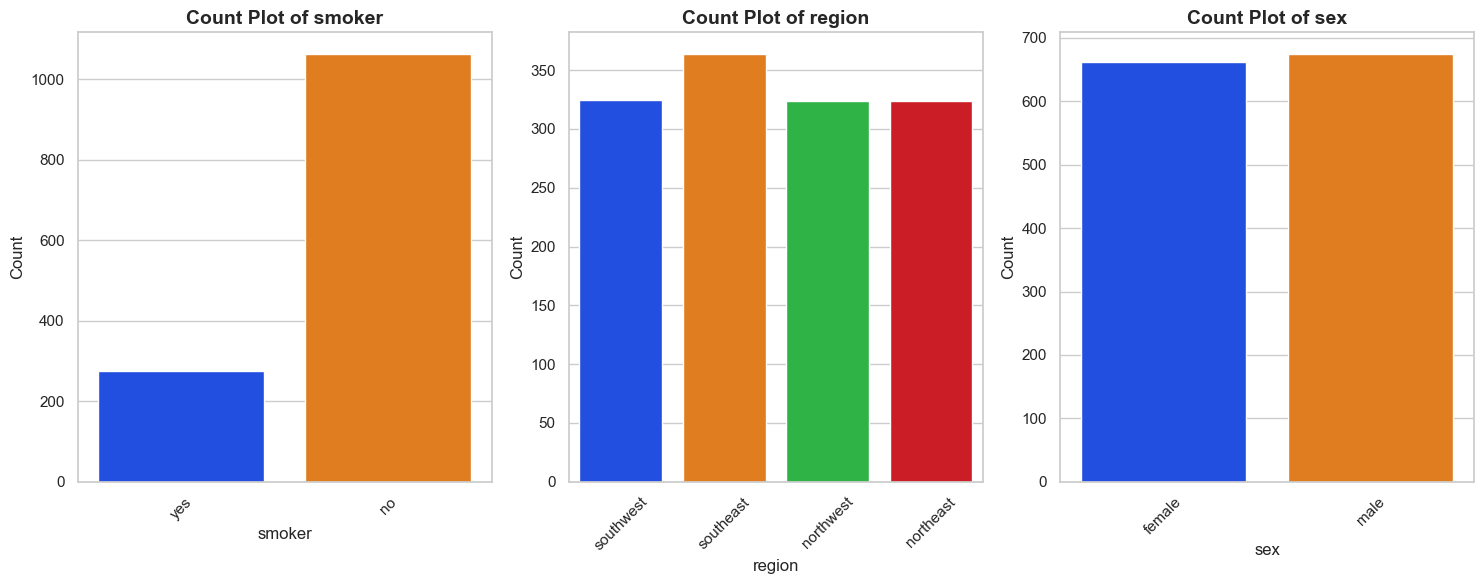

09/02/2025 10:21:36 : INFO : Check van categorische features


In [23]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright')
    plt.title(f"Count Plot of {col}", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische features countplot")
plt.show()
log_info("Check van categorische features")

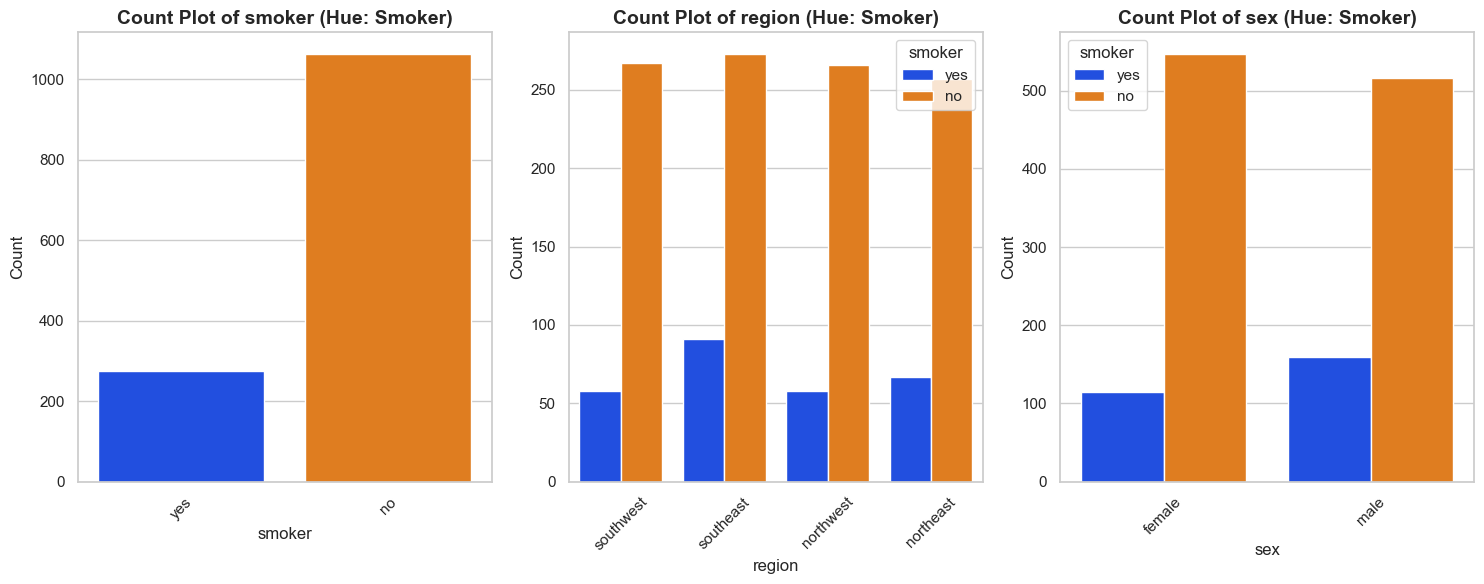

In [24]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright', hue='smoker')
    plt.title(f"Count Plot of {col} (Hue: Smoker)", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische variabelen tov smoker")
plt.show()

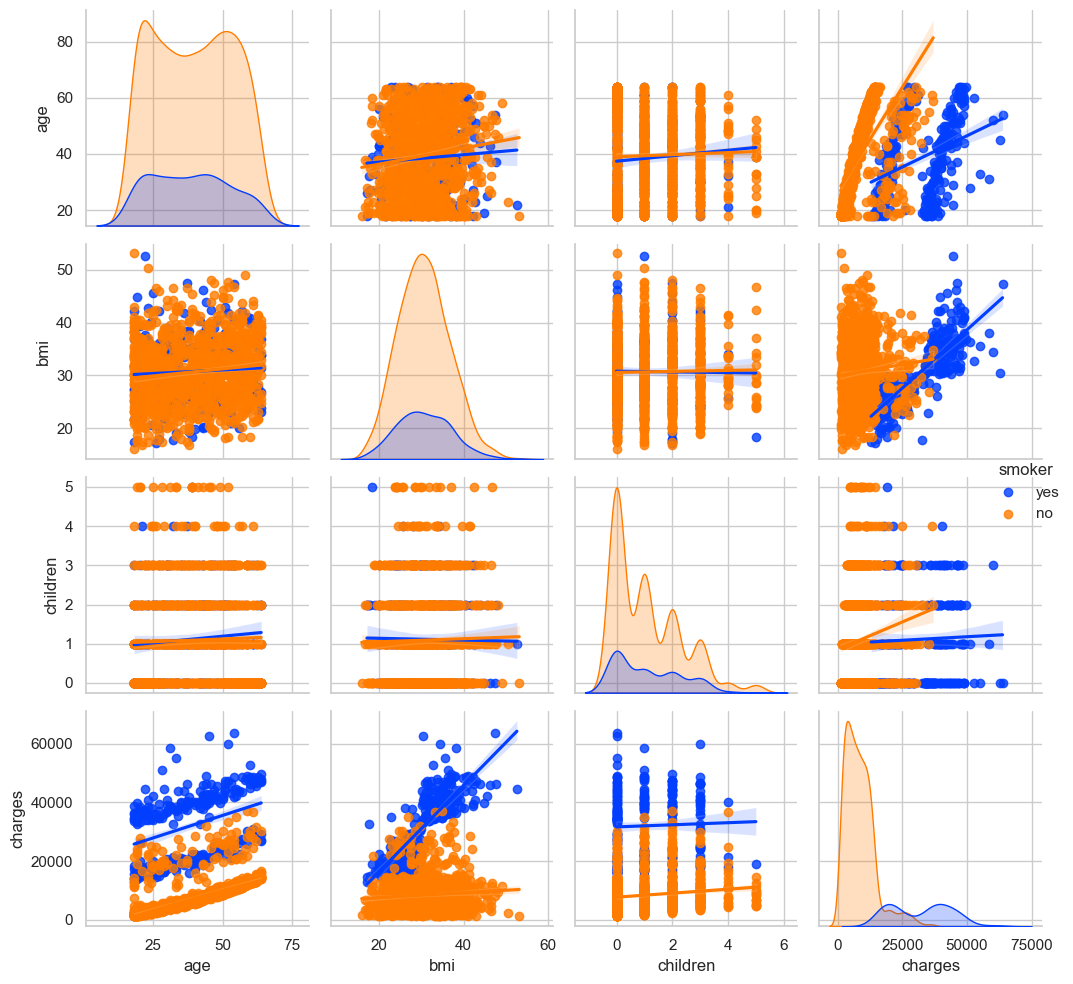

In [25]:
sns.pairplot(df, hue='smoker',  kind='reg')
plt.tight_layout()
save_fig("Numerische features onderlinge scatter")
plt.show()

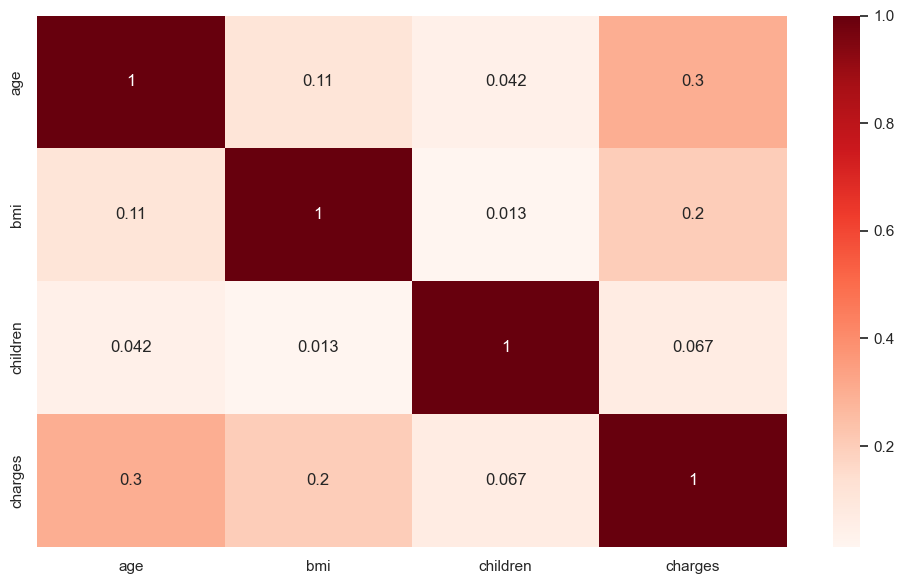

In [26]:
# print de correlation nog af tussen de numerische waarden

plt.figure(figsize=(10, 6))
sns.heatmap(df[df_num_col].corr(), annot=True, cmap='Reds')
save_fig("Numerische features correlatie")
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest


def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])

    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df['outlier'] = labels
    outliers = df[df['outlier'] == -1]
    percentage_aantal_outliers = (len(outliers) / len(df)) * 100
    return percentage_aantal_outliers


percentage_aantal_outliers = bereken_percentage_aantal_outliers(df, ['bmi','charges'])
print(percentage_aantal_outliers)

In [ ]:




# Initialiseren van het Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit het model
iso_forest.fit(df[['bmi','charges']])

# Voorspellingen
# Het geeft -1 voor outliers en 1 voor inliers
labels = iso_forest.predict(df[['bmi','charges']])
# Toevoegen van de labels aan het DataFrame om outliers te identificeren
df['outlier'] = labels
outliers = df[df['outlier'] == -1]
aantal_outliers = df['outlier'].value_counts()
# er zijn wel wat outliers...
# we gaan ze moeten oplossen
# we zullen dit doen via Capping (Winsorizing)
print(aantal_outliers)

def cap_values(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# DataFrame en kolom aanpassen
df_adjusted = cap_values(df, 'bmi')

# NOG NIET GETEST

outlier
 1    980
-1    357
Name: count, dtype: int64


In [ ]:
# opdelen train - test - set

# gebruik maken van stratefy en op basis van de categorisatie van de charges
# om ervoor te zorgen dat in de train - test split zelfde verhoudingen voorkomen

df["charges_cat"] = pd.cut(df["charges"],
                               bins=[0, 10000, 20000, 30000, np.inf],
                               labels=[1, 2, 3, 4, 5])

df.head()




NameError: name 'pd' is not defined